In [2]:
import pandas as pd
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
import re
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import pickle
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
#CARGAMOS EL DATAFRAME CON LAS COLUMNAS QUE NOS INTERESAN PARA EL MODELO
dfml = pd.read_csv('df_ml.csv',parse_dates=[0],usecols=['Full_date','Channel','Simul_cast_channel','Sales_house'
                                                        ,'Day_name','Month_name'
                                                        ,'Public','Year','Hour','Minute','Day_number','Month_number','Week_number'
                                                        ,'Time_frame','Genre','Adults_avg_audience'])

In [18]:
#CARGAMOS EL DF DE UNA SOLA CADENA PARA PROBAR EL MODELO SARIMAX
dfsar = pd.read_csv('SARIMAX/SAR_atres.csv',index_col=0)

In [13]:
#ELIMINAMOS LOS REGISTROS DE 2020 QUE VAN DE MARZO EN ADELANTE POR EL COVID
df_ant = dfml[dfml.Full_date <= datetime.datetime(2020,2,29,23,59,0)]

# Análisis preliminar

In [45]:
dfml.describe()

,Hour,Minute,Day_number,Week_number,Month_number,Year,Adults_avg_audience
count,2.536146e+07,2.536146e+07,2.536146e+07,2.536146e+07,2.536146e+07,2.536146e+07,2.536146e+07
mean,1.149642e+01,2.950059e+01,1.566018e+01,2.482690e+01,6.138134e+00,2.018578e+03,6.201662e-01
std,6.920401e+00,1.731827e+01,8.831668e+00,1.538415e+01,3.544175e+00,9.139804e-01,1.066244e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.017000e+03,0.000000e+00
25%,5.000000e+00,1.500000e+01,8.000000e+00,1.200000e+01,3.000000e+00,2.018000e+03,8.000000e-02
50%,1.100000e+01,3.000000e+01,1.600000e+01,2.400000e+01,6.000000e+00,2.019000e+03,2.470000e-01
75%,1.700000e+01,4.500000e+01,2.300000e+01,3.800000e+01,9.000000e+00,2.019000e+03,6.330000e-01
max,2.300000e+01,5.900000e+01,3.100000e+01,5.200000e+01,1.200000e+01,2.020000e+03,9.999000e+00


In [46]:
dfml.corr()

,Hour,Minute,Day_number,Week_number,Month_number,Year,Adults_avg_audience
Hour,1.000000,-0.000028,-0.000056,0.000153,0.000163,-0.000381,0.325149
Minute,-0.000028,1.000000,-0.000006,0.000014,0.000011,-0.000056,-0.001509
Day_number,-0.000056,-0.000006,1.000000,0.066750,0.001562,-0.000510,-0.002287
Week_number,0.000153,0.000014,0.066750,1.000000,0.981569,-0.294069,-0.023246
Month_number,0.000163,0.000011,0.001562,0.981569,1.000000,-0.302305,-0.024031
Year,-0.000381,-0.000056,-0.000510,-0.294069,-0.302305,1.000000,0.012587
Adults_avg_audience,0.325149,-0.001509,-0.002287,-0.023246,-0.024031,0.012587,1.000000


In [17]:
df_prev.corr()

,Hour,Minute,Year,Adults_avg_audience,Day_name_Monday,Day_name_Saturday,Day_name_Sunday,Day_name_Thursday,Day_name_Tuesday,Day_name_Wednesday,...,Genre_MUSICA,Genre_OTROS,Genre_PROGRAMAS DE VENTAS,Genre_PUBLICIDAD,Genre_RELIGIOSOS,Genre_TOROS,Public_DESCONOCIDO,Public_FAMILIAR,Public_NIÑOS,Public_NO DISPONIBLE
Hour,1.000000,-0.000048,-0.000174,0.325192,0.000680,0.000037,-0.000092,-0.000395,-0.000454,0.000038,...,-0.207130,-0.010537,-0.185924,0.160437,-0.010129,-0.000437,0.002667,-0.052339,-0.040208,0.160249
Minute,-0.000048,1.000000,-0.000031,-0.001658,0.000065,-0.000025,-0.000011,-0.000021,-0.000036,-0.000010,...,0.002506,-0.001614,-0.000029,0.020572,-0.010987,-0.000934,-0.000566,-0.004771,-0.005616,0.020393
Year,-0.000174,-0.000031,1.000000,-0.007468,-0.006512,0.002844,-0.003409,0.002691,-0.001229,0.002814,...,-0.006453,-0.007600,0.014192,-0.001805,0.005874,0.000580,-0.002415,-0.006305,-0.015322,-0.001710
Adults_avg_audience,0.325192,-0.001658,-0.007468,1.000000,0.009787,-0.020003,0.008283,-0.001425,0.004370,0.002761,...,-0.111874,-0.002220,-0.146134,0.046294,-0.027273,0.000775,0.001762,-0.063283,-0.047074,0.046148
Day_name_Monday,0.000680,0.000065,-0.006512,0.009787,1.000000,-0.167064,-0.166293,-0.167003,-0.167053,-0.167063,...,-0.001808,-0.017287,0.006049,0.003223,-0.009440,-0.001414,-0.002782,-0.002763,-0.007065,0.003174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Genre_TOROS,-0.000437,-0.000934,0.000580,0.000775,-0.001414,0.000394,0.000443,0.000100,0.000357,0.000099,...,-0.000729,-0.000188,-0.000910,-0.001359,-0.000210,1.000000,-0.000028,0.002128,-0.000320,-0.001170
Public_DESCONOCIDO,0.002667,-0.000566,-0.002415,0.001762,-0.002782,-0.001484,-0.001447,0.003679,-0.000424,0.001306,...,-0.001724,0.048384,-0.002152,-0.003213,-0.000497,-0.000028,1.000000,-0.012455,-0.000755,-0.003214
Public_FAMILIAR,-0.052339,-0.004771,-0.006305,-0.063283,-0.002763,-0.015707,-0.007645,0.004431,0.004751,0.005402,...,0.136375,0.033421,0.171839,-0.598894,0.036418,0.002128,-0.012455,1.000000,-0.140831,-0.599161
Public_NIÑOS,-0.040208,-0.005616,-0.015322,-0.047074,-0.007065,0.019118,0.016534,-0.007239,-0.007397,-0.006788,...,-0.019179,-0.004853,-0.024337,-0.036326,-0.005295,-0.000320,-0.000755,-0.140831,1.000000,-0.036342


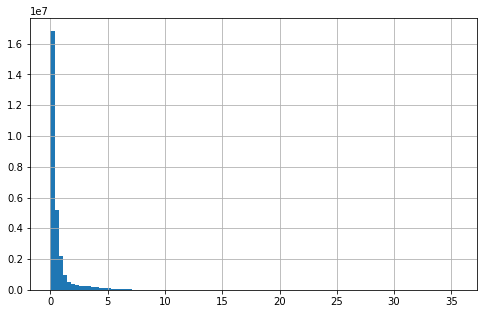

In [14]:
#EN EL GRÁFICO SE APRECIA DONDE SE CONCENTRAN LA MAYOR PARTE DE LOS VALORES
df_ant.Adults_avg_audience.hist(bins=100, figsize=(8,5))

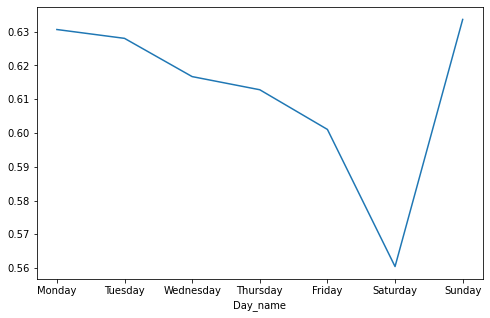

In [15]:
#AUDIENCIA MEDIA POR DÍA
dia = df_ant.groupby('Day_name')['Adults_avg_audience'].mean()
dia[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]].plot(figsize=(8, 5))

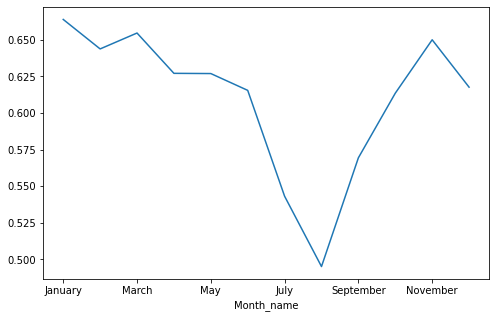

In [16]:
#AUDIENCIA MEDIA POR MES
mes = df_ant.groupby('Month_name')['Adults_avg_audience'].mean()
mes[['January', 'February' ,'March','April', 'May','June','July', 'August', 'September','October','November', 'December']].plot(figsize=(8, 5))

#### Conclusiones del análisis preliminar
Se observa que las columnas seleccionadas aportan información independiente unas de otras, a excepción del número de semana y el número de mes.
A través de los gráficos observamos varias cosas:
- La mayor parte de los valores de audiencia se concentran entorno al 0 y al 2. Los valores mayores son los menos.
- La audiencia media por días se comporta de tal manera que durante los domingos y lunes se prodecen los picos de máxima audiencia, a lo largo de la semana va bajando, hasta llegar a su valor mínimo el sábado.
- En cuanto a la audiencia media por mes, se observa que los meses de verano concentran los valores mínimos, se produce un repunte de agosto a noviembre, en diciembre vuelve a bajar, para luego subir en enero y bajar paulatinamente hasta los meses de verano.

Los comportamientos observados a través de las gráficas siguen el patrón normal de consumo televisivo. También se toma la decisión, a través del histograma, de eleminar los valores de audiencia mayores de 10.

In [4]:
#ELIMINAMOS OUTLIERS
df_ant = df_ant[dfml.Adults_avg_audience < 10]

In [ ]:
#CODIFICAMOS LAS VARIABLES CATEGÓRICAS
df_prev = pd.get_dummies(df_ant, prefix_sep='_', drop_first=True)

In [8]:
#DIVIDIMOS EN TRAIN Y TEST 
X = df_prev.drop(['Adults_avg_audience','Full_date'], axis=1)
y = df_prev.Adults_avg_audience
X = X.rename(columns={'Genre_FICCIÓN':'Genre_FICCION','Genre_INFORMACIÓN':'Genre_INFORMACION',
                      'Genre_ARTES ESCÉNICAS':'Genre_ARTES ESCENICAS','Public_NIÑOS':'Public_NINOS' })
X_train,X_test,y_train,y_test = train_test_split(X, y , test_size = 0.1)

# SARIMAX
Se desarrolla un pequeño modelo para comprobar su funcionamiento a grandes rasgos, y para ver los resultados que producen los datos cargados.

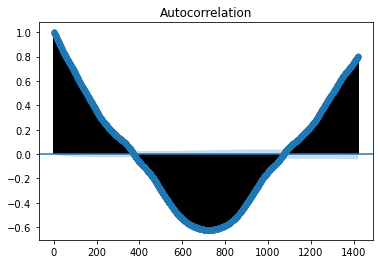

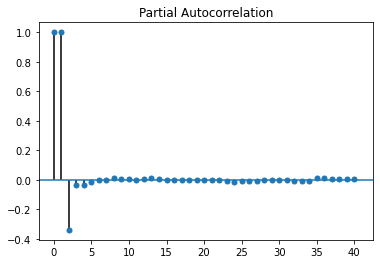

In [51]:
plot_acf(dfsar,lags = 1420, unbiased = True)
plot_pacf(dfsar, lags = 40)
plt.show()

In [19]:
model = SARIMAX(dfsar, order = (3, 0, 2)).fit()
prediction = model.get_forecast(steps = 1400)

C:\Users\Marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\Marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be i

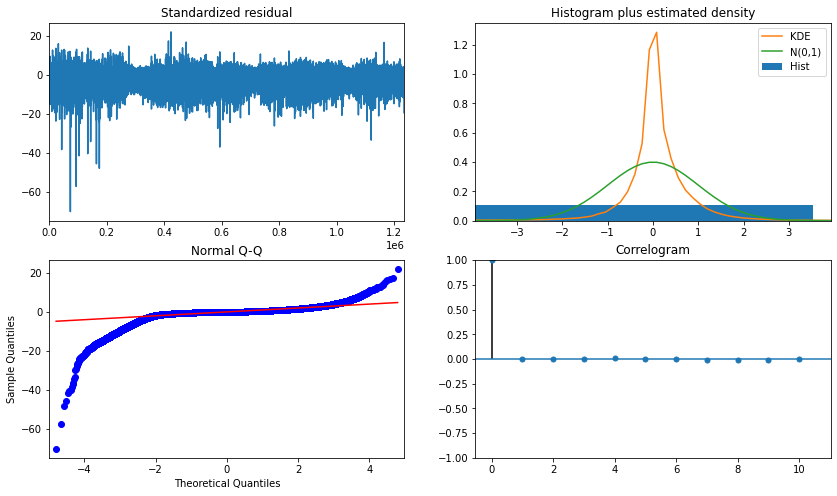

In [52]:
model.plot_diagnostics(figsize = (14, 8))
plt.show()

# Random Forest
Se realizan varias pruebas con este modelo, y se valora su funcionamiento a través del error medio absoluto. Con este dato lo compararemos con futuros modelos.

In [10]:
#SE QUITÓ FECHA,DATE,GENRE,AGE_RATING,PUBLIC Y TITULO(SIN HOR Y MIN)
X_train,X_test,y_train,y_test = train_test_split(cop, y , test_size = 0.1)
clf = RandomForestRegressor(max_depth=4)
clf.fit(X_train, y_train)
print(mean_absolute_error(clf.predict(X_test),y_test))

0.41634236372482647


In [11]:
#TODAS LAS COLUMNAS INCLUIDAS(SIN HOR Y MIN)
clf = RandomForestRegressor(max_depth=5)
clf.fit(X_train, y_train)
print(mean_absolute_error(clf.predict(X_test),y_test))

0.39519689874904534


In [11]:
#SE QUITÓ FECHA,DATE,GENRE,AGE_RATING,PUBLIC Y TITULO(SIN HOR Y MIN)
X_train,X_test,y_train,y_test = train_test_split(cop, y , test_size = 0.1)
clf = RandomForestRegressor(max_depth=6)
clf.fit(X_train, y_train)
print(mean_absolute_error(clf.predict(X_test),y_test))

0.36396723181238666


In [22]:
#SE QUITÓ 'Full_date','Title/Descrip','Production_comp','Age_rating','Date','Audience_checker'
X_train,X_test,y_train,y_test = train_test_split(cop, y , test_size = 0.1)
clf = RandomForestRegressor(max_depth=6)
clf.fit(X_train, y_train)
print(mean_absolute_error(clf.predict(X_test),y_test))

0.3248287151294288


In [33]:
#SE QUITÓ 'Full_date','Title/Descrip','Production_comp','Age_rating','Date','Audience_checker'
X_train,X_test,y_train,y_test = train_test_split(cop, y , test_size = 0.1)
reg = RandomForestRegressor(max_depth=6 , min_samples_split= 3 , min_samples_leaf= 2)
reg.fit(X_train, y_train)
print(mean_absolute_error(reg.predict(X_test),y_test))

0.32461471645174933


# Gradien Boost
En esta parte se realiza una única prueba con el modelo Gradient Boost. Se espera obtener mejores resultados que con el Random Forest.

In [13]:
#GRADIENTBOOST SIN'Full_date','Title/Descrip','Production_comp','Age_rating','Date','Audience_checker'
X_train,X_test,y_train,y_test = train_test_split(X, y , test_size = 0.1)
clf = GradientBoostingRegressor(max_depth=6)
clf.fit(X_train, y_train)
print(mean_absolute_error(clf.predict(X_test),y_test))
print(sqrt(mean_squared_error(y_test,clf.predict(X_test))))

filename = 'modelo_uno_LightGBM.pkl'
pickle.dump(lghtreg, open(filename, 'wb'))

0.16326332994903617
0.3644429963409199


# LightGBM
A continuación se prueba un algoritmo relativamente nuevo, con ciertas similitudes con el Gradient Boost. Acudir a la memoria del proyecto para más información.

In [14]:
#PROBAMOS LIGHTGBM
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.3
params['boosting_type'] = 'gbdt'
params['application'] = 'regression'
params['metric'] = 'mae'
params['num_leaves'] = 64
params['min_data'] = 1100
params['max_depth'] = 6
lghtreg = lgb.train(params, d_train, 100)
print(mean_absolute_error(lghtreg.predict(X_test),y_test))
print(sqrt(mean_squared_error(y_test,lghtreg.predict(X_test))))

0.14454808644643
0.32813362845185584


In [11]:
#BUSQUEDA DE HIPERPARAMETROS OPTIMIZADOS 
param_grid = {}
param_grid['learning_rate'] = [0.3,0.03,0.001,0.1]
param_grid['boosting_type'] = ['gbdt','dart']
param_grid['application'] = ['regression']
param_grid['metric'] = ['mae']
param_grid['num_leaves'] = [64,50,40,30,70,100]
param_grid['min_data'] = [500,700,900,1100,1200]
param_grid['max_depth'] = [3,4,5,6,7]
param_grid['n_estimators'] =[100,200,300]

reg_test = RandomizedSearchCV(lgb.LGBMRegressor(),
 param_grid,n_iter=10, scoring='neg_mean_absolute_error')
# Fit will test all of the combinations
reg_test.fit(X_train,y_train)
# Best estimator and best parameters
print(reg_test.best_score_,
reg_test.best_estimator_,
reg_test.best_params_)

filename = 'modelo_tres_0-141_LightGBM.pkl'
pickle.dump(reg_test, open(filename, 'wb'))

-0.14115249518861311 LGBMRegressor(application='regression', learning_rate=0.3, max_depth=5,
              metric='mae', min_data=1100, n_estimators=300, num_leaves=100) {'num_leaves': 100, 'n_estimators': 300, 'min_data': 1100, 'metric': 'mae', 'max_depth': 5, 'learning_rate': 0.3, 'boosting_type': 'gbdt', 'application': 'regression'}


In [61]:
#PROBAMOS LIGHTGBM CON LAS COLUMNAS DE WEEKNUMBER Y TIMEMACHINE INCLUIDAS
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.3
params['boosting_type'] = 'gbdt'
params['application'] = 'regression'
params['metric'] = 'mae'
params['num_leaves'] = 55
params['min_data'] = 950
params['max_depth'] = 7
params['n_estimators'] = 300
lghtreg = lgb.train(params, d_train, 100)
print(mean_absolute_error(lghtreg.predict(X_test),y_test))

C:\Users\Marta\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0.12865160835484


In [44]:
#MODELO SIN OUTLIERS
reg = lgb.LGBMRegressor(application='regression', learning_rate=0.3, max_depth=7,
              metric='mae', min_data=2500, n_estimators=950, num_leaves=100) 
reg.fit(X_train,y_train)
print(mean_absolute_error(y_test,reg.predict(X_test)))
print(sqrt(mean_squared_error(y_test,reg.predict(X_test))))

filename = 'modelo_catorce_0_1032_LightGBM.pkl'
pickle.dump(reg, open(filename, 'wb'))

0.10318713875510609
0.20861872742560522


In [38]:
#MODELO CON OUTLIERS
reg = lgb.LGBMRegressor(application='regression', learning_rate=0.3, max_depth=7,
              metric='mae', min_data=2500, n_estimators=950, num_leaves=100) 
reg.fit(X_train,y_train)
print(mean_absolute_error(y_test,reg.predict(X_test)))
print(sqrt(mean_squared_error(y_test,reg.predict(X_test))))

filename = 'modelo_quince_conoutliers_LightGBM.pkl'
pickle.dump(reg, open(filename, 'wb'))

0.1191071586914255
0.24976117025667047


In [55]:
#GUARDAMOS EL MODELO LIGHTGBMREG, CON UN MAE DE 0.1214
filename = 'modelo_trece_0_1123_LightGBM.pkl'
pickle.dump(reg, open(filename, 'wb'))

In [11]:
reg = lgb.LGBMRegressor(application='regression', learning_rate=0.3, max_depth=7,
              metric='mae', min_data=2000, n_estimators=850, num_leaves=90) 
reg.fit(X_train,y_train)
print(mean_absolute_error(reg.predict(X_test),y_test))

0.15507219746611256


In [44]:
#BUSQUEDA DE HIPERPARAMETROS OPTIMIZADOS 

param_grid = {}
param_grid['learning_rate'] = [0.3,0.03,0.001,0.1]
param_grid['boosting_type'] = ['gbdt','dart']
param_grid['application'] = ['regression']
param_grid['metric'] = ['mae']
param_grid['num_leaves'] = [64,50,40,30,70,100]
param_grid['min_data'] = [500,700,900,1100,1200]
param_grid['max_depth'] = [3,4,5,6,7]
param_grid['n_estimators'] =[100,200,300]

reg_test = RandomizedSearchCV(lgb.LGBMRegressor(),
 param_grid,n_iter=8, scoring='neg_mean_absolute_error')
# Fit will test all of the combinations
reg_test.fit(X_train,y_train)
# Best estimator and best parameters
print(reg_test.best_score_,
reg_test.best_estimator_,
reg_test.best_params_)

-0.12501066019687906 LGBMRegressor(application='regression', learning_rate=0.3, max_depth=7,
              metric='mae', min_data=700, n_estimators=300, num_leaves=40) {'num_leaves': 40, 'n_estimators': 300, 'min_data': 700, 'metric': 'mae', 'max_depth': 7, 'learning_rate': 0.3, 'boosting_type': 'gbdt', 'application': 'regression'}


In [7]:
param_grid = {}
param_grid['learning_rate'] = [0.3]
param_grid['boosting_type'] = ['gbdt']
param_grid['application'] = ['regression']
param_grid['metric'] = ['mae']
param_grid['num_leaves'] = [95,110]
param_grid['min_data'] = [2000,2200]
param_grid['max_depth'] = [7]
param_grid['n_estimators'] =[950,850]

reg_test = RandomizedSearchCV(lgb.LGBMRegressor(),
 param_grid,n_iter=7, scoring='neg_mean_absolute_error')
# Fit will test all of the combinations
reg_test.fit(X_train,y_train)
# Best estimator and best parameters
print(reg_test.best_score_,
reg_test.best_estimator_,
reg_test.best_params_)
print(mean_absolute_error(y_test,reg_test.predict(X_test)))
print(sqrt(mean_squared_error(y_test,reg_test.predict(X_test))))

-0.1029788871194625 LGBMRegressor(application='regression', learning_rate=0.3, max_depth=7,
              metric='mae', min_data=2000, n_estimators=950, num_leaves=110) {'num_leaves': 110, 'n_estimators': 950, 'min_data': 2000, 'metric': 'mae', 'max_depth': 7, 'learning_rate': 0.3, 'boosting_type': 'gbdt', 'application': 'regression'}


NameError: name 'lghtreg' is not defined

In [9]:
#MODELO CON PARAMETROS OPTIMIZADOS
regres_lgbm = lgb.LGBMRegressor(application='regression', learning_rate=0.3, max_depth=7,
              metric='mae', min_data=2000, n_estimators=950, num_leaves=110) 
regres_lgbm.fit(X_train,y_train)
print(mean_absolute_error(y_test,regres_lgbm.predict(X_test)))
print(sqrt(mean_squared_error(y_test,regres_lgbm.predict(X_test))))

filename = 'modelo_DIECISEIS_sinoutliers_opt_0_1017_LightGBM.pkl'
pickle.dump(regres_lgbm, open(filename, 'wb'))

0.10174006850764598
0.2048359196638323


In [7]:
param_grid = {}
param_grid['learning_rate'] = [0.3]
param_grid['boosting_type'] = ['gbdt']
param_grid['application'] = ['regression']
param_grid['metric'] = ['mae']
param_grid['num_leaves'] = [210,110]
param_grid['min_data'] = [2000,2300]
param_grid['max_depth'] = [7]
param_grid['n_estimators'] =[950,1050]

reg_test = RandomizedSearchCV(lgb.LGBMRegressor(),
 param_grid,n_iter=7, scoring='neg_mean_absolute_error')
# Fit will test all of the combinations
reg_test.fit(X_train,y_train)
# Best estimator and best parameters
print(reg_test.best_score_,
reg_test.best_estimator_,
reg_test.best_params_)
print(mean_absolute_error(y_test,reg_test.predict(X_test)))
print(sqrt(mean_squared_error(y_test,reg_test.predict(X_test))))

-0.10189803409568868 LGBMRegressor(application='regression', learning_rate=0.3, max_depth=7,
              metric='mae', min_data=2000, n_estimators=1050, num_leaves=210) {'num_leaves': 210, 'n_estimators': 1050, 'min_data': 2000, 'metric': 'mae', 'max_depth': 7, 'learning_rate': 0.3, 'boosting_type': 'gbdt', 'application': 'regression'}
0.10086322113297118
0.20280284805203747


In [7]:
reg_lgbm_opt = lgb.LGBMRegressor(application='regression', learning_rate=0.3, max_depth=7,metric='mae', min_data=2000, 
              n_estimators=1050, num_leaves=210)
reg_lgbm_opt.fit(X_train,y_train)
print(mean_absolute_error(y_test,reg_lgbm_opt.predict(X_test)))
print(sqrt(mean_squared_error(y_test,reg_lgbm_opt.predict(X_test))))

filename = 'modelo_diecisiete_sinoutliers_opt_0_1033_LightGBM.pkl'
pickle.dump(reg_lgbm_opt, open(filename, 'wb'))

0.1033362168970056
0.20950230683812346


## Conclusion
Tras haber analizado distintos modelos, se escoge el LightGBM como algoritmo definitivo. Se puede observar que las métricas utilizas para cuantificar la precisión del modelo resultan mínimas para este algoritmo

# Predicción en contínuo
Se dispone de un dataframe ficticio aportado por la agencia de medios. Corresponde al año 2021, y con el se realizarán predicciones para la totalidad del año. Una vez realizadas las predicciones, se alamacenarán con el resto de datos para su posterior visualización.

In [3]:
dfcont = pd.read_csv('df_ficticio.csv',parse_dates=[0],usecols=['Full_date','Channel','Simul_cast_channel','Sales_house'
                                                        ,'Day_name','Month_name'
                                                        ,'Public','Year','Hour','Minute','Day_number','Month_number','Week_number'
                                                        ,'Time_frame','Genre','Adults_avg_audience'])

In [4]:
dfcod = pd.get_dummies(dfcont,prefix_sep='_', drop_first=True)
dfcod = dfcod.rename(columns={'Genre_FICCIÓN':'Genre_FICCION','Genre_INFORMACIÓN':'Genre_INFORMACION',
                      'Genre_ARTES ESCÉNICAS':'Genre_ARTES ESCENICAS','Public_NIÑOS':'Public_NINOS' })

In [5]:
filename = 'modelo_diecisiete_sinoutliers_opt_0_1033_LightGBM.pkl'
loaded_model = pickle.load(open(filename, 'rb'))
dfcont.Adults_avg_audience = loaded_model.predict(dfcod.drop(['Adults_avg_audience','Full_date'], axis=1))

In [6]:
dfcontcomp = pd.read_csv('df_ficticio.csv', index_col=0)
dfmltot = pd.read_csv('df_ml.csv',index_col=0)

C:\Users\Marta\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
dfcontcomp.Adults_avg_audience = dfcont.Adults_avg_audience.values

In [8]:
dfinal = pd.concat([dfmltot,dfcontcomp])

In [9]:
dfinal.reset_index(drop=True, inplace=True)

In [10]:
dfinal.to_csv('df_ml_21.csv')